Target: 
        setup with simple network (Based on Example 6 notebook from class)
        Set Transforms, Data Loader, training and test loop
        achieve accuracy around 98.7%

Result:
        Parameters: 6010
        train accuracy: 98.57%
        test accuracy: 99.08%

Analysis:
        With limited parameters, network is stable and learning to fullest.
        Room to increase network capacity (get parameters to 8000).
        Improve  test accuracy to 99.3%.



In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Data Transformations
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
SEED = 99

cuda = torch.cuda.is_available()

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#data loader arguments - something you will fetch these from cmdt prompt
train_dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

test_dataloader_args = dict(shuffle=False, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=False, batch_size=64)

train_dataloader = torch.utils.data.DataLoader(train, **train_dataloader_args)
test_dataloader = torch.utils.data.DataLoader(test, **test_dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Statistics
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('Train Data Stats:')
print('- Numpy Shape ', train.train_data.cpu().numpy().shape)
print('- Tensor shape ', train.train_data.size())
print('- Min ', torch.min(train_data))
print('- Max ', torch.max(train_data))
print('- mean ', torch.mean(train_data))
print('- Std ', torch.std(train_data))
print('- var ', torch.var(train_data))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Train Data Stats:
- Numpy Shape  (60000, 28, 28)
- Tensor shape  torch.Size([60000, 28, 28])
- Min  tensor(-0.4242)
- Max  tensor(2.8215)
- mean  tensor(-0.0001)
- Std  tensor(1.0000)
- var  tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


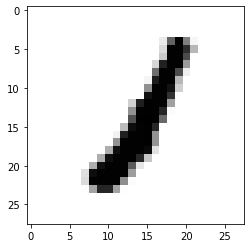

In [ ]:
# Print some images
diter = iter(train_dataloader)
images, labels = diter.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

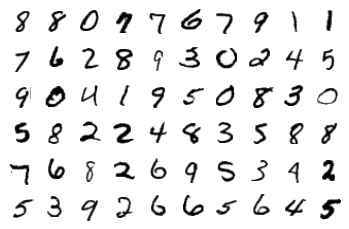

In [ ]:
figure = plt.figure()
num_images = 60
for index in range(1, num_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

In [ ]:
dropout_value = 0.10

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    #Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(dropout_value)
    )#output_size=26
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(dropout_value)
    )#output_size=24

    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3,3), padding=0, bias=False),
        #nn.ReLU()
    )#output_size=22

    self.pool1 = nn.MaxPool2d(2,2)#output_size=11


    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(dropout_value)
    )#output_size=11

    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(dropout_value)
    )#output_size=9

    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(20),
        nn.Dropout(dropout_value)
    )#output_size=7

    self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
    )#output_size=7

    #output block
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=7)
    )#output_size=1



  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = self.pool1(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.gap(x)

    x = x.view(-1, 10)

    return F.log_softmax(x, dim=1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             200
             ReLU-12           [-1, 10, 11, 11]               0
      BatchNorm2d-13           [-1, 10, 11, 11]              20
          Dropout-14           [-1

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_dataloader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.18697881698608398 Batch_id=468 Accuracy=77.65: 100%|██████████| 469/469 [00:20<00:00, 22.60it/s]



Test set: Average loss: 0.1822, Accuracy: 9554/10000 (95.54%)

EPOCH: 1


Loss=0.13892579078674316 Batch_id=468 Accuracy=95.88: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]



Test set: Average loss: 0.0809, Accuracy: 9783/10000 (97.83%)

EPOCH: 2


Loss=0.08300847560167313 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]



Test set: Average loss: 0.0642, Accuracy: 9822/10000 (98.22%)

EPOCH: 3


Loss=0.05006556585431099 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]



Test set: Average loss: 0.0641, Accuracy: 9807/10000 (98.07%)

EPOCH: 4


Loss=0.03792529180645943 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:20<00:00, 22.39it/s]



Test set: Average loss: 0.0555, Accuracy: 9830/10000 (98.30%)

EPOCH: 5


Loss=0.023738639429211617 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]



Test set: Average loss: 0.0430, Accuracy: 9870/10000 (98.70%)

EPOCH: 6


Loss=0.06591950356960297 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]



Test set: Average loss: 0.0464, Accuracy: 9850/10000 (98.50%)

EPOCH: 7


Loss=0.059913162142038345 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]



Test set: Average loss: 0.0436, Accuracy: 9872/10000 (98.72%)

EPOCH: 8


Loss=0.025652214884757996 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:20<00:00, 22.39it/s]



Test set: Average loss: 0.0367, Accuracy: 9889/10000 (98.89%)

EPOCH: 9


Loss=0.017369581386446953 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]



Test set: Average loss: 0.0336, Accuracy: 9893/10000 (98.93%)

EPOCH: 10


Loss=0.06042053923010826 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]



Test set: Average loss: 0.0340, Accuracy: 9896/10000 (98.96%)

EPOCH: 11


Loss=0.04264339432120323 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]



Test set: Average loss: 0.0347, Accuracy: 9886/10000 (98.86%)

EPOCH: 12


Loss=0.04193318262696266 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:20<00:00, 22.39it/s]



Test set: Average loss: 0.0334, Accuracy: 9899/10000 (98.99%)

EPOCH: 13


Loss=0.02847287245094776 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]



Test set: Average loss: 0.0298, Accuracy: 9901/10000 (99.01%)

EPOCH: 14


Loss=0.052676811814308167 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]



Test set: Average loss: 0.0304, Accuracy: 9908/10000 (99.08%)

EPOCH: 15


Loss=0.015246863476932049 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]



Test set: Average loss: 0.0339, Accuracy: 9899/10000 (98.99%)

EPOCH: 16


Loss=0.04820035398006439 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]



Test set: Average loss: 0.0304, Accuracy: 9908/10000 (99.08%)

EPOCH: 17


Loss=0.012052789330482483 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]



Test set: Average loss: 0.0289, Accuracy: 9903/10000 (99.03%)

EPOCH: 18


Loss=0.03798382729291916 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]



Test set: Average loss: 0.0325, Accuracy: 9893/10000 (98.93%)

EPOCH: 19


Loss=0.0352485366165638 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]



Test set: Average loss: 0.0276, Accuracy: 9914/10000 (99.14%)



Text(0.5, 1.0, 'Test Accuracy')

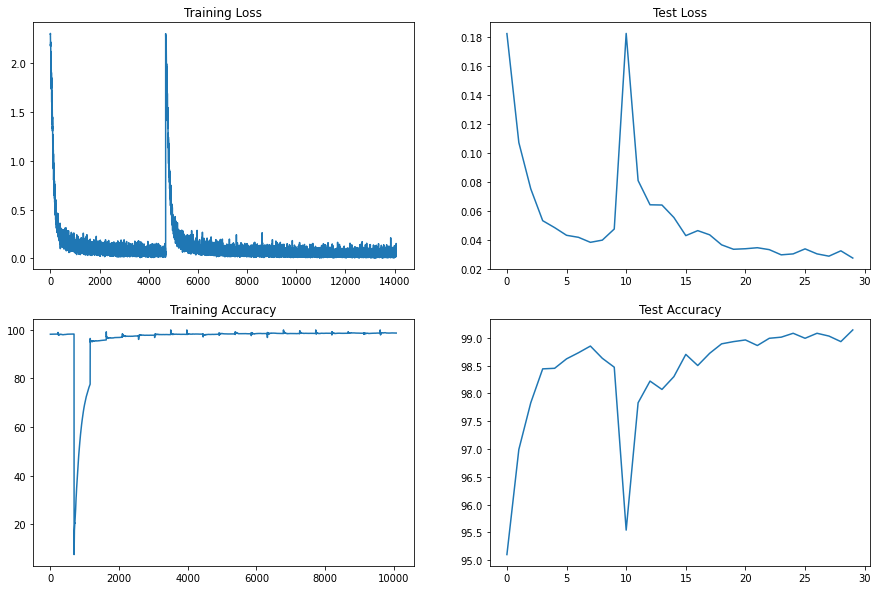

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")